In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os

import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from datetime import datetime

In [3]:
# Read data
data = pd.read_csv('../data/model_features.csv')
# data = pd.read_csv('../data/transformed_data_men_21_to_24.csv')
# data.drop('Unnamed: 0',axis=1,inplace=True)
data.columns = [col.replace('%','_perc') for col in data.columns]
data.columns = [col.replace('3','three_') for col in data.columns]
data.head()

,won,underdog,underdog_opp,fan_favorite,fan_favorite_opp,de,oe,te,pace,physicality_score,...,luck_opp,choke_rate,choke_rate_opp,upset_rate,upset_rate_opp,three_mean_plus_minus,three_mean_plus_minus_opp,win_streak,win_streak_opp,matchup_win_rate
0,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.000000,0.0,NaN,0.0,NaN,14.333333,-3.333333,0,0,NaN
1,1,0,0,0,1,83.955939,105.172414,1.25271,72.0,9.405172,...,0.571429,0.0,NaN,0.0,NaN,14.333333,-0.333333,1,2,NaN
2,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.444444,0.0,NaN,0.0,0.000000,14.333333,-5.666667,2,1,NaN
3,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.000000,0.0,NaN,0.0,NaN,14.333333,-10.333333,3,0,0.5
4,0,1,0,0,1,83.955939,105.172414,1.25271,72.0,9.405172,...,0.333333,0.0,0.3,0.0,0.444444,13.666667,21.333333,4,2,NaN


In [4]:
data[['gpt_sent_score_avg']]

Index(['won', 'underdog', 'underdog_opp', 'fan_favorite', 'fan_favorite_opp',
       'de', 'oe', 'te', 'pace', 'physicality_score', 'sos', 'srs', 'fg',
       'fga', 'fg_perc', 'three_p', 'three_pa', 'three_p_perc', 'ft', 'fta',
       'ft_perc', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'pf', 'tov',
       'tov_perc', 'poss', 'ast_per_poss', 'ast_per_fg', 'tov_per_poss',
       'ast_to_tov', 'poss_per_game', 'game_win_rate', 'gpt_sent_score_avg',
       'gpt_sent_score_avg.1', 'de_opp', 'oe_opp', 'te_opp', 'pace_opp',
       'physicality_score_opp', 'sos_opp', 'srs_opp', 'fg_opp', 'fga_opp',
       'fg_perc_opp', 'three_p_opp', 'three_pa_opp', 'three_p_perc_opp',
       'ft_opp', 'fta_opp', 'ft_perc_opp', 'orb_opp', 'drb_opp', 'trb_opp',
       'ast_opp', 'stl_opp', 'blk_opp', 'pf_opp', 'tov_opp', 'tov_perc_opp',
       'poss_opp', 'ast_per_poss_opp', 'ast_per_fg_opp', 'tov_per_poss_opp',
       'ast_to_tov_opp', 'poss_per_game_opp', 'game_win_rate_opp',
       'gpt_sent_score_avg_opp

In [ ]:
# Check for duplicates
num_duplicates = data.loc[data.duplicated()].shape[0]
print(f'{num_duplicates} duplicates')
if num_duplicates > 0:
#     print(data.loc[data.duplicated()].head())
    data = data.drop_duplicates()
    print('duplicates removed')

## Create helper functions

In [ ]:
def get_odds_ratios(model, save_name=None):
    # Build a dataframe with odds ratios and their confidence intervals.
    if type(model) in [type(LogisticRegression()), type(XGBClassifier())]:
#         params = np.concatenate((model.intercept_, model.coef_[0]),axis=0)
        params = pd.Series(model.coef_[0],index=model.feature_names_in_)
    else:
        params = model.params
    odds_ratios = pd.DataFrame(
        {
            "OR": params
#             "Lower CI": model.conf_int()[0],
#             "Upper CI": model.conf_int()[1],
        }
    )
    # Exponentiate the data frame
    odds_ratios = np.exp(odds_ratios)

    # Print the odds ratios
#     or_string = 
    print('\nOdds Ratios:')
    print(odds_ratios.sort_values('OR',ascending=False))
    odds_ratios.sort_values('OR',ascending=False).to_csv(f'../eda/{save_name}_odds_ratios.csv')
    
    # Print prediction table
    if type(model) not in [type(LogisticRegression()), type(XGBClassifier())]:
        print('\nPrediction table:')
        print(model.pred_table())
    if save_name is not None:
        np.savetxt(f'../eda/{save_name}_prediction_table.out',model.pred_table(),
                   header=f'{save_name} prediction table')
    
    return None

In [ ]:
def get_confusion_matrix(model, validation, response_var):
    y_pred = model.predict(validation)
    prediction = list(map(round, y_pred))

    # Create a sklearn confusion matrix
    cm = confusion_matrix(validation[response_var], prediction)
    print ("\nConfusion Matrix : \n", cm)

    # We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
    print('\nTest accuracy = ', accuracy_score(validation[response_var], prediction))
    
    # Print classfication report
    print('\nClassification Report: \n' , classification_report(validation[response_var],prediction))
    
    return None

## 1 - Statsmodels Logistic Regression

In [ ]:
resp_var = data.columns[0]
pred_vars = data.columns[1:].tolist()

train, test = train_test_split(data,test_size=0.1)
logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)
log_reg = sm.logit(logit_phrase, data=train).fit(method='bfgs')
y_pred = log_reg.predict(test)
prediction = list(map(round, y_pred))

false_positive_rate, true_positive_rate, threshold1 = roc_curve(test[resp_var], prediction)
print(f'Accuracy: {accuracy_score(test[resp_var], prediction)}')
print(f'F1-Score: {f1_score(test[resp_var], prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(test[resp_var], prediction))

In [ ]:
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
get_odds_ratios(log_reg)

#### 1-A Remove possibly confounding features

In [ ]:
data.columns
exclude_columns = ['matchup_win_rate','choke_rate','choke_rate_opp','luck','luck_opp',
                   'upset_rate','upset_rate_opp']
data2 = data.drop(exclude_columns, axis=1)
resp_var = data2.columns[0]
pred_vars = data2.columns[1:].tolist()

train, test = train_test_split(data2,test_size=0.1)
logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)
log_reg = sm.logit(logit_phrase, data=train).fit(method='bfgs')
y_pred = log_reg.predict(test)
prediction = list(map(round, y_pred))

false_positive_rate, true_positive_rate, threshold1 = roc_curve(test[resp_var], prediction)
print(f'Accuracy: {accuracy_score(test[resp_var], prediction)}')
print(f'F1-Score: {f1_score(test[resp_var], prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(test[resp_var], prediction))

In [ ]:
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
get_odds_ratios(log_reg)

## 2 - Sklearn Logistic Regression

In [ ]:
y = data.iloc[:, 0] #selects the first column (wins)
X = data.iloc[:, 1:] #selects all columns except the win column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = LogisticRegression(max_iter=1000)  # Increase max_iter if the model doesn't converge
model.fit(X_train, y_train)

prediction = model.predict(X_test)

false_positive_rate, true_positive_rate, threshold1 = roc_curve(
    y_test, model.predict_proba(X_test)[:,1])
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'F1-Score: {f1_score(y_test, prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(y_test, prediction))

get_odds_ratios(model)

In [ ]:
plt.title('Receiver Operating Characteristic - Sklearn Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3 - Xgboost

In [ ]:
pd.options.display.max_columns = 100

In [ ]:
model = XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100, 
    learning_rate = 0.02,
    max_depth = 5,
    gamma = 5,
    min_child_weight = 10,
    subsample = .8
)
model.fit(X_train, y_train)

prediction = model.predict(X_test)

false_positive_rate, true_positive_rate, threshold1 = roc_curve(
    y_test, model.predict_proba(X_test)[:,1])
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'F1-Score: {f1_score(y_test, prediction)}')
print('ROC/AUC Score for Xgboost: ', roc_auc_score(y_test, prediction))

# get_odds_ratios(model)

In [ ]:
plt.title('Receiver Operating Characteristic - Xgboost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Grid Search for Xgboost

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1)

In [ ]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [50]:
# Check for duplicates
num_duplicates = data.loc[data.duplicated()].shape[0]
print(f'{num_duplicates} duplicates')
if num_duplicates > 0:
#     print(data.loc[data.duplicated()].head())
    data = data.drop_duplicates()
    print('duplicates removed')

120 duplicates
duplicates removed


## Create helper functions

In [166]:
def get_odds_ratios(model, save_name=None):
    # Build a dataframe with odds ratios and their confidence intervals.
    if type(model) in [type(LogisticRegression()), type(XGBClassifier())]:
#         params = np.concatenate((model.intercept_, model.coef_[0]),axis=0)
        params = pd.Series(model.coef_[0],index=model.feature_names_in_)
    else:
        params = model.params
    odds_ratios = pd.DataFrame(
        {
            "OR": params
#             "Lower CI": model.conf_int()[0],
#             "Upper CI": model.conf_int()[1],
        }
    )
    # Exponentiate the data frame
    odds_ratios = np.exp(odds_ratios)

    # Print the odds ratios
#     or_string = 
    print('\nOdds Ratios:')
    print(odds_ratios.sort_values('OR',ascending=False))
    odds_ratios.sort_values('OR',ascending=False).to_csv(f'../eda/{save_name}_odds_ratios.csv')
    
    # Print prediction table
    if type(model) not in [type(LogisticRegression()), type(XGBClassifier())]:
        print('\nPrediction table:')
        print(model.pred_table())
    if save_name is not None:
        np.savetxt(f'../eda/{save_name}_prediction_table.out',model.pred_table(),
                   header=f'{save_name} prediction table')
    
    return None

In [68]:
def get_confusion_matrix(model, validation, response_var):
    y_pred = model.predict(validation)
    prediction = list(map(round, y_pred))

    # Create a sklearn confusion matrix
    cm = confusion_matrix(validation[response_var], prediction)
    print ("\nConfusion Matrix : \n", cm)

    # We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
    print('\nTest accuracy = ', accuracy_score(validation[response_var], prediction))
    
    # Print classfication report
    print('\nClassification Report: \n' , classification_report(validation[response_var],prediction))
    
    return None

## 1 - Statsmodels Logistic Regression

In [81]:
resp_var = data.columns[0]
pred_vars = data.columns[1:].tolist()

train, test = train_test_split(data,test_size=0.1)
logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)
log_reg = sm.logit(logit_phrase, data=train).fit(method='bfgs')
y_pred = log_reg.predict(test)
prediction = list(map(round, y_pred))

false_positive_rate, true_positive_rate, threshold1 = roc_curve(test[resp_var], prediction)
print(f'Accuracy: {accuracy_score(test[resp_var], prediction)}')
print(f'F1-Score: {f1_score(test[resp_var], prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(test[resp_var], prediction))

         Current function value: 0.448688
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
Accuracy: 0.7857142857142857
F1-Score: 0.7834562697576396
ROC/AUC Score for Logistic Regression:  0.7858684467715211


C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


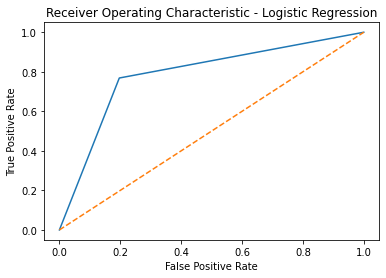

In [86]:
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
get_odds_ratios(log_reg)


Odds Ratios:
                         OR  Lower CI  Upper CI
matchup_win_rate   8.364590       NaN       NaN
luck               2.499675       NaN       NaN
game_win_rate      1.613030       NaN       NaN
fan_favorite       1.558582       NaN       NaN
upset_rate         1.284219       NaN       NaN
...                     ...       ...       ...
srs_opp            0.876485       NaN       NaN
upset_rate_opp     0.803861       NaN       NaN
fan_favorite_opp   0.632787       NaN       NaN
game_win_rate_opp  0.609932       NaN       NaN
luck_opp           0.403085       NaN       NaN

[82 rows x 3 columns]

Prediction table:
[[13615.  3639.]
 [ 3855. 13407.]]


#### 1-A Remove possibly confounding features

In [91]:
data.columns
exclude_columns = ['matchup_win_rate','choke_rate','choke_rate_opp','luck','luck_opp',
                   'upset_rate','upset_rate_opp']
data2 = data.drop(exclude_columns, axis=1)
resp_var = data2.columns[0]
pred_vars = data2.columns[1:].tolist()

train, test = train_test_split(data2,test_size=0.1)
logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)
log_reg = sm.logit(logit_phrase, data=train).fit(method='bfgs')
y_pred = log_reg.predict(test)
prediction = list(map(round, y_pred))

false_positive_rate, true_positive_rate, threshold1 = roc_curve(test[resp_var], prediction)
print(f'Accuracy: {accuracy_score(test[resp_var], prediction)}')
print(f'F1-Score: {f1_score(test[resp_var], prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(test[resp_var], prediction))

         Current function value: 0.479665
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
Accuracy: 0.7606882168925965
F1-Score: 0.7559808612440191
ROC/AUC Score for Logistic Regression:  0.7606630894563685


C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\nwheatle\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


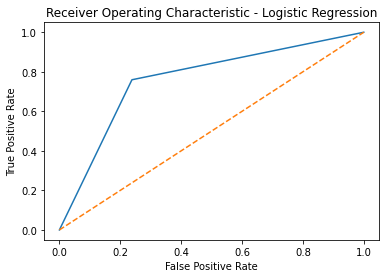

In [92]:
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [93]:
get_odds_ratios(log_reg)


Odds Ratios:
                          OR  Lower CI  Upper CI
game_win_rate      10.625782       NaN       NaN
underdog            1.762710       NaN       NaN
fan_favorite        1.473077       NaN       NaN
poss_per_game_opp   1.413852       NaN       NaN
pace                1.239943       NaN       NaN
...                      ...       ...       ...
fga                 0.811411       NaN       NaN
fan_favorite_opp    0.671622       NaN       NaN
poss_per_game       0.632839       NaN       NaN
underdog_opp        0.589429       NaN       NaN
game_win_rate_opp   0.089788       NaN       NaN

[75 rows x 3 columns]

Prediction table:
[[13120.  4093.]
 [ 4160. 13143.]]


## 2 - Sklearn Logistic Regression

In [153]:
y = data.iloc[:, 0] #selects the first column (wins)
X = data.iloc[:, 1:] #selects all columns except the win column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = LogisticRegression(max_iter=1000)  # Increase max_iter if the model doesn't converge
model.fit(X_train, y_train)

prediction = model.predict(X_test)

false_positive_rate, true_positive_rate, threshold1 = roc_curve(
    y_test, model.predict_proba(X_test)[:,1])
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'F1-Score: {f1_score(y_test, prediction)}')
print('ROC/AUC Score for Logistic Regression: ', roc_auc_score(y_test, prediction))

get_odds_ratios(model)

Accuracy: 0.7836287799791449
F1-Score: 0.7820378151260504
ROC/AUC Score for Logistic Regression:  0.7836287799791449

Odds Ratios:
                         OR
game_win_rate      6.813596
matchup_win_rate   5.744312
luck               2.035772
upset_rate         1.495901
fan_favorite       1.445202
...                     ...
choke_rate         0.804596
upset_rate_opp     0.700496
fan_favorite_opp   0.609678
luck_opp           0.518066
game_win_rate_opp  0.136297

[81 rows x 1 columns]


C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


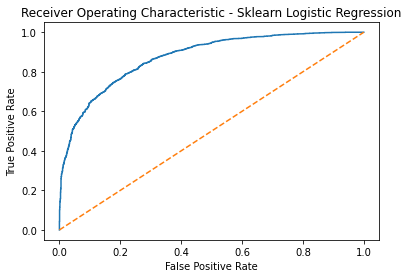

In [154]:
plt.title('Receiver Operating Characteristic - Sklearn Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3 - Xgboost

In [197]:
pd.options.display.max_columns = 100

In [193]:
model = XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100, 
    learning_rate = 0.02,
    max_depth = 5,
    gamma = 5,
    min_child_weight = 10,
    subsample = .8
)
model.fit(X_train, y_train)

prediction = model.predict(X_test)

false_positive_rate, true_positive_rate, threshold1 = roc_curve(
    y_test, model.predict_proba(X_test)[:,1])
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'F1-Score: {f1_score(y_test, prediction)}')
print('ROC/AUC Score for Xgboost: ', roc_auc_score(y_test, prediction))

# get_odds_ratios(model)

Accuracy: 0.7849322210636079
F1-Score: 0.7794707297514034
ROC/AUC Score for Xgboost:  0.7849322210636079


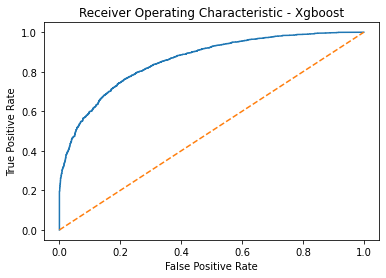

In [170]:
plt.title('Receiver Operating Characteristic - Xgboost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Grid Search for Xgboost

In [179]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [180]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [188]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1)

In [194]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[10:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



 Time taken: 0 hours 1 minutes and 0.68 seconds.


In [190]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([ 5.71665724,  5.65834936,  8.47132953, 10.23006447, 12.28322983]), 'std_fit_time': array([0.10900781, 0.07105301, 0.07435012, 0.07223454, 0.22617717]), 'mean_score_time': array([0.09430456, 0.08398644, 0.07843351, 0.08662256, 0.08521215]), 'std_score_time': array([0.01275547, 0.00806786, 0.00021364, 0.00639928, 0.00557539]), 'param_subsample': masked_array(data=[1.0, 0.8, 0.6, 0.6, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 5, 1, 5, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[4, 3, 4, 4, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[1.5, 5, 0.5, 0.5, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
    